In [78]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

In [79]:
data = pd.read_csv("HK/top3.csv").drop('Unnamed: 0', axis = 1)
geo_data  = gpd.read_file("HK/Hong_Kong_18_Districts/Hong_Kong_18_Districts.shp").drop('TCNAME', axis = 1)

In [80]:
data.head(3)

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,69074,160139,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408,3,130,1,159
1,103760,304876,CENTRAL & WESTERN,22.28407,114.15570,Entire home/apt,853,2,260,12,329
2,132773,304876,CENTRAL & WESTERN,22.28868,114.14494,Entire home/apt,1056,2,259,12,308


In [81]:
geo_data.head(3)

,OBJECTID,ENAME,Shape__Are,Shape__Len,geometry
0,1,WONG TAI SIN,1.092784e+07,17995.640782,"POLYGON ((114.17942 22.34905, 114.17946 22.349..."
1,2,KWAI TSING,2.774914e+07,56392.256966,"MULTIPOLYGON (((114.11265 22.36046, 114.11283 ..."
2,3,SHAM SHUI PO,1.116098e+07,29302.817383,"POLYGON ((114.14684 22.34417, 114.14796 22.345..."


In [82]:
data = data[data.price <= 6000].drop(['host_id','minimum_nights','number_of_reviews'
                  ,'calculated_host_listings_count','availability_365'], axis = 1)
geo_data = geo_data.drop(['OBJECTID','Shape__Are','Shape__Len'], axis = 1)

In [83]:
geo_data["geometry_lat"] = geo_data.centroid.y
geo_data["geometry_lon"] = geo_data.centroid.x

In [84]:
geo_data.loc[geo_data.ENAME == 'YAU TSIM MONG',"geometry_lat"] = 22.295062
geo_data.loc[geo_data.ENAME == 'YAU TSIM MONG',"geometry_lon"] = 114.171865
geo_data.loc[geo_data.ENAME == 'WAN CHAI',"geometry_lat"] = 22.280025 
geo_data.loc[geo_data.ENAME == 'WAN CHAI',"geometry_lon"] = 114.173477
geo_data.loc[geo_data.ENAME == 'CENTRAL & WESTERN',"geometry_lat"] = 22.280641
geo_data.loc[geo_data.ENAME == 'CENTRAL & WESTERN',"geometry_lon"] = 114.159040

In [85]:
geo_data.head()

,ENAME,geometry,geometry_lat,geometry_lon
0,WONG TAI SIN,"POLYGON ((114.17942 22.34905, 114.17946 22.349...",22.344019,114.204175
1,KWAI TSING,"MULTIPOLYGON (((114.11265 22.36046, 114.11283 ...",22.349604,114.117428
2,SHAM SHUI PO,"POLYGON ((114.14684 22.34417, 114.14796 22.345...",22.333509,114.155566
3,YAU TSIM MONG,"MULTIPOLYGON (((114.15306 22.32312, 114.15309 ...",22.295062,114.171865
4,KOWLOON CITY,"MULTIPOLYGON (((114.19659 22.31134, 114.19657 ...",22.323138,114.188037


In [86]:
data.head()

,id,neighbourhood,latitude,longitude,room_type,price
0,69074,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408
1,103760,CENTRAL & WESTERN,22.28407,114.15570,Entire home/apt,853
2,132773,CENTRAL & WESTERN,22.28868,114.14494,Entire home/apt,1056
3,133390,CENTRAL & WESTERN,22.28343,114.15539,Entire home/apt,939
4,163214,CENTRAL & WESTERN,22.28494,114.15251,Entire home/apt,1048


In [87]:
top_3 = pd.merge(data, geo_data, how='inner', left_on='neighbourhood', right_on='ENAME').drop(['ENAME',], axis = 1).drop(['geometry'], axis=1)
top_3.head()

,id,neighbourhood,latitude,longitude,room_type,price,geometry_lat,geometry_lon
0,69074,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408,22.280641,114.15904
1,103760,CENTRAL & WESTERN,22.28407,114.15570,Entire home/apt,853,22.280641,114.15904
2,132773,CENTRAL & WESTERN,22.28868,114.14494,Entire home/apt,1056,22.280641,114.15904
3,133390,CENTRAL & WESTERN,22.28343,114.15539,Entire home/apt,939,22.280641,114.15904
4,163214,CENTRAL & WESTERN,22.28494,114.15251,Entire home/apt,1048,22.280641,114.15904


In [88]:
import geopy.distance

In [89]:
top_3['distance_geodesic'] = top_3.apply(
    (lambda row: geopy.distance.geodesic(
        (row['latitude'], row['longitude']),
        (row['geometry_lat'], row['geometry_lon'])
    ).m),
    axis=1
)

top_3['distance_great_circle'] = top_3.apply(
    (lambda row: geopy.distance.great_circle(
        (row['latitude'], row['longitude']),
        (row['geometry_lat'], row['geometry_lon'])
    ).m),
    axis=1
)

In [90]:
top_3.head(2)

,id,neighbourhood,latitude,longitude,room_type,price,geometry_lat,geometry_lon,distance_geodesic,distance_great_circle
0,69074,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408,22.280641,114.15904,967.137433,966.198608
1,103760,CENTRAL & WESTERN,22.28407,114.15570,Entire home/apt,853,22.280641,114.15904,512.500912,513.304633


1. convert the whole datafrme to geodataframe
2. merge the lat and lon into one geometric "point" column
2. calculate the distance to each corresponding central point

In [91]:
set(top_3.room_type)

{'Entire home/apt', 'Private room', 'Shared room'}

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# CENTRAL & WESTERN

In [93]:
cen = top_3[top_3.neighbourhood == 'CENTRAL & WESTERN']

In [94]:
cen_en = cen[cen.room_type == 'Entire home/apt']
cen_pr = cen[cen.room_type == 'Private room']
cen_sh = cen[cen.room_type == 'Shared room']

In [95]:
x1 = cen_en[['distance_geodesic']]
y1 = cen_en[['price']]
model = LinearRegression()
model.fit(x1,y1)

cen_en_pred = model.predict(x1)

print('Coefficients of the Entire home/apt: \n', model.coef_[0], model.intercept_)
# model.score(x1, y1)
metrics.r2_score(y1, cen_en_pred)

Coefficients of the Entire home/apt: 
 [-0.0741606] [1024.27449936]


0.013476173695506799

In [96]:
x2 = cen_pr[['distance_geodesic']]
y2 = cen_pr[['price']]
model = LinearRegression()
model.fit(x2,y2)

cen_pr_pred = model.predict(x2)

print('Coefficients of the Private room: \n', model.coef_[0], model.intercept_)
model.score(x2, y2)

Coefficients of the Private room: 
 [-0.01428289] [506.2150233]


0.0006434287787940862

In [97]:
x3 = cen_sh[['distance_geodesic']]
y3 = cen_sh[['price']]
model = LinearRegression()
model.fit(x3,y3)

cen_sh_pred = model.predict(x3)

print('Coefficients of the Shared room: \n', model.coef_[0], model.intercept_)
model.score(x3, y3)

Coefficients of the Shared room: 
 [-0.0038064] [453.6569117]


6.783472777061039e-05

Text(0.5, 1.0, 'The relationship between price and diatance to centre in CENTRAL&WESTERN')

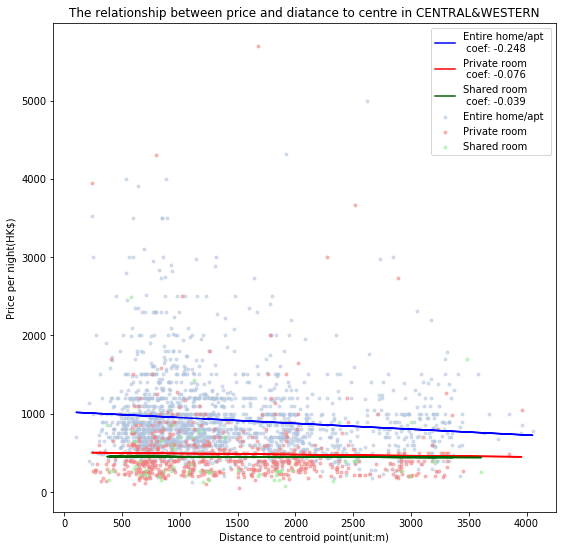

In [98]:
# Plot outputs
plt.figure(figsize=(9,9))
plt.scatter(cen_en.distance_geodesic, cen_en.price, marker = '.', color = 'lightsteelblue', alpha = 0.5 ,label = 'Entire home/apt')
plt.scatter(cen_pr.distance_geodesic, cen_pr.price, marker = '.', color = 'lightcoral', alpha = 0.5, label ='Private room')
plt.scatter(cen_sh.distance_geodesic, cen_sh.price, marker = '.', color = 'lightgreen', alpha = 0.5, label ='Shared room')
plt.plot(x1, cen_en_pred, color = 'blue', label ='Entire home/apt \n coef: -0.248')
plt.plot(x2, cen_pr_pred, color = 'red', label ='Private room \n coef: -0.076')
plt.plot(x3, cen_sh_pred, color = 'darkgreen', label ='Shared room \n coef: -0.039')
plt.gca().set_xlabel('Distance to centroid point(unit:m)')
plt.gca().set_ylabel('Price per night(HK$)')
plt.legend()
plt.title('The relationship between price and diatance to centre in CENTRAL&WESTERN')

# WAN CHAI 

In [99]:
wan = top_3[top_3.neighbourhood == 'WAN CHAI']

In [100]:
wan_en = wan[wan.room_type == 'Entire home/apt']
wan_pr = wan[wan.room_type == 'Private room']
wan_sh = wan[wan.room_type == 'Shared room']

In [101]:
x1 = wan_en[['distance_geodesic']]
y1 = wan_en[['price']]
model = LinearRegression()
model.fit(x1,y1)

wan_en_pred = model.predict(x1)

print('Coefficients of the Entire home/apt: \n', model.coef_[0], model.intercept_)
model.score(x1, y1)

Coefficients of the Entire home/apt: 
 [-0.05342822] [1006.73798965]


0.0035447236859689206

In [102]:
x2 = wan_pr[['distance_geodesic']]
y2 = wan_pr[['price']]
model = LinearRegression()
model.fit(x2,y2)

wan_pr_pred = model.predict(x2)

print('Coefficients of the Private room: \n', model.coef_[0], model.intercept_)
model.score(x2, y2)

Coefficients of the Private room: 
 [-0.08602352] [532.70097798]


0.06983752635027218

In [103]:
x3 = wan_sh[['distance_geodesic']]
y3 = wan_sh[['price']]
model = LinearRegression()
model.fit(x3,y3)

wan_sh_pred = model.predict(x3)

print('Coefficients of the Shared room: \n', model.coef_[0], model.intercept_)
model.score(x3, y3)

Coefficients of the Shared room: 
 [0.04853919] [261.60729988]


0.03706921855165679

Text(0.5, 1.0, 'The relationship between price and diatance to centre in WAN CHI')

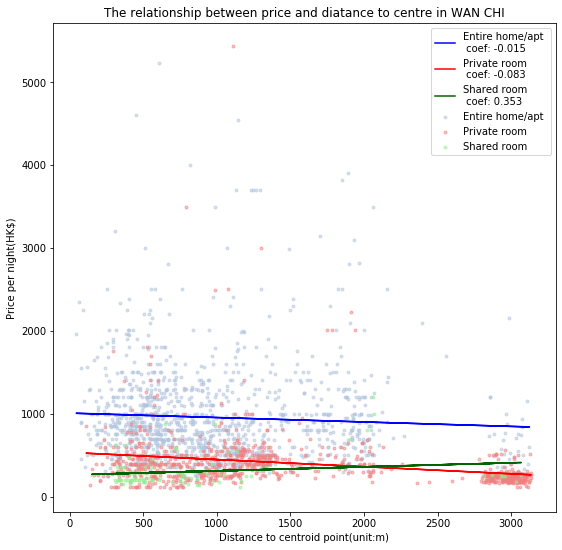

In [104]:
# Plot outputs
plt.figure(figsize=(9,9))
plt.scatter(wan_en.distance_geodesic, wan_en.price, marker = '.', color = 'lightsteelblue', alpha = 0.5 ,label = 'Entire home/apt')
plt.scatter(wan_pr.distance_geodesic, wan_pr.price, marker = '.', color = 'lightcoral', alpha = 0.5, label ='Private room')
plt.scatter(wan_sh.distance_geodesic, wan_sh.price, marker = '.', color = 'lightgreen', alpha = 0.5, label ='Shared room')
plt.plot(x1, wan_en_pred, color = 'blue', label ='Entire home/apt \n coef: -0.015')
plt.plot(x2, wan_pr_pred, color = 'red', label ='Private room \n coef: -0.083')
plt.plot(x3, wan_sh_pred, color = 'darkgreen', label ='Shared room \n coef: 0.353')
plt.gca().set_xlabel('Distance to centroid point(unit:m)')
plt.gca().set_ylabel('Price per night(HK$)')
plt.legend()
plt.title('The relationship between price and diatance to centre in WAN CHI')

# YAU TSIM MONG

In [105]:
yau = top_3[top_3.neighbourhood == 'YAU TSIM MONG']

In [121]:
yau.shape

(4698, 10)

In [106]:
yau_en = yau[yau.room_type == 'Entire home/apt']
yau_pr = yau[yau.room_type == 'Private room']
yau_sh = yau[yau.room_type == 'Shared room']

In [122]:
x1 = yau_en[['distance_geodesic']]
y1 = yau_en[['price']]
model = LinearRegression()
model.fit(x1,y1)

yau_en_pred = model.predict(x1)

print('Coefficients of the Entire home/apt: \n', model.coef_[0], model.intercept_)
print('R squared:',model.score(x1, y1))

Coefficients of the Entire home/apt: 
 [-0.04374695] [985.83641155]
R squared: 0.004973914122665013


In [108]:
x2 = yau_pr[['distance_geodesic']]
y2 = yau_pr[['price']]
model = LinearRegression()
model.fit(x2,y2)

yau_pr_pred = model.predict(x2)

print('Coefficients of the Private room: \n', model.coef_[0], model.intercept_)
model.score(x2, y2)

Coefficients of the Private room: 
 [-0.0348535] [535.74817965]


0.009747286443584136

In [109]:
x3 = yau_sh[['distance_geodesic']]
y3 = yau_sh[['price']]
model = LinearRegression()
model.fit(x3,y3)

yau_sh_pred = model.predict(x3)

print('Coefficients of the Shared room: \n', model.coef_[0], model.intercept_)
model.score(x3, y3)

Coefficients of the Shared room: 
 [-0.06175354] [382.53809459]


0.0387564491983029

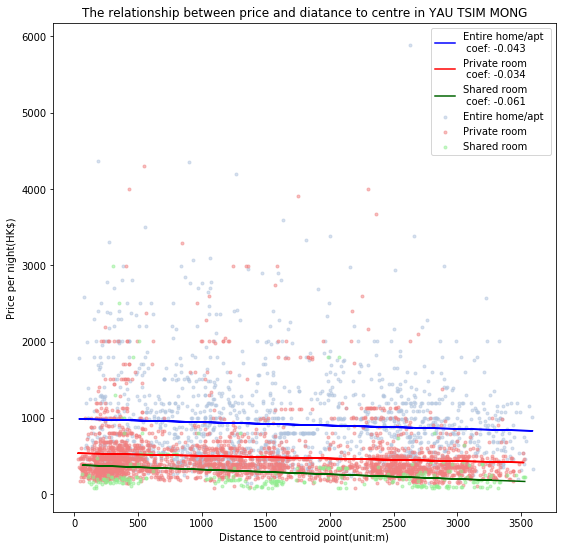

In [126]:
# Plot outputs
plt.figure(figsize=(9,9))
plt.scatter(yau_en.distance_geodesic, yau_en.price, marker = '.', color = 'lightsteelblue', alpha = 0.5 ,label = 'Entire home/apt')
plt.scatter(yau_pr.distance_geodesic, yau_pr.price, marker = '.', color = 'lightcoral', alpha = 0.5, label ='Private room')
plt.scatter(yau_sh.distance_geodesic, yau_sh.price, marker = '.', color = 'lightgreen', alpha = 0.5, label ='Shared room')
plt.plot(x1, yau_en_pred, color = 'blue', label ='Entire home/apt \n coef: -0.043')
plt.plot(x2, yau_pr_pred, color = 'red', label ='Private room \n coef: -0.034')
plt.plot(x3, yau_sh_pred, color = 'darkgreen', label ='Shared room \n coef: -0.061')
plt.gca().set_xlabel('Distance to centroid point(unit:m)')
plt.gca().set_ylabel('Price per night(HK$)')
plt.legend()
plt.title('The relationship between price and diatance to centre in YAU TSIM MONG')
# plt.savefig('YAU.png')

In [111]:
import folium

In [112]:
cen.head(1)

,id,neighbourhood,latitude,longitude,room_type,price,geometry_lat,geometry_lon,distance_geodesic,distance_great_circle
0,69074,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408,22.280641,114.15904,967.137433,966.198608


In [113]:
wan.head(1)

,id,neighbourhood,latitude,longitude,room_type,price,geometry_lat,geometry_lon,distance_geodesic,distance_great_circle
7313,262212,WAN CHAI,22.27626,114.17293,Entire home/apt,1314,22.280025,114.173477,420.707734,422.41594


In [114]:
yau.head(1)

,id,neighbourhood,latitude,longitude,room_type,price,geometry_lat,geometry_lon,distance_geodesic,distance_great_circle
2615,228510,YAU TSIM MONG,22.30983,114.16911,Private room,696,22.295062,114.171865,1659.782099,1666.408704


In [118]:
latlon = [ (22.280641, 114.15904), (22.280025, 114.173477), (22.295062, 114.171865)]

In [119]:
mapit = folium.Map( location=[ 22.290, 114.176 ], zoom_start= 14 )
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ],icon=folium.Icon(color='red', icon='info-sign')).add_to( mapit )


In [120]:
mapit